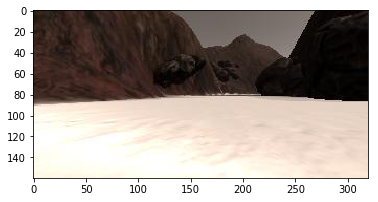

In [4]:
# Import some packages from matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Uncomment the next line for use in a Jupyter notebook
#%matplotlib inline

# Define the filename, read and plot the image
filename = '../test_dataset/IMG/robocam_2018_04_16_17_42_01_185.jpg'
image = mpimg.imread(filename)
plt.imshow(image)
plt.show()


uint8 (160, 320, 3) 0 255


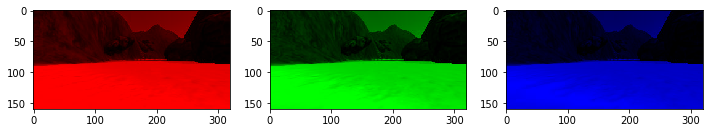

In [5]:
import numpy as np
print(image.dtype, image.shape, np.min(image), np.max(image))
# uint8 (160, 320, 3) 0 255

# Note: we use the np.copy() function rather than just saying red_channel = image
# because in Python, such a statement would set those two arrays equal to each other
# forever, meaning any changes made to one would also be made to the other!
red_channel = np.copy(image)
# Note: here instead of extracting individual channels from the image
# I'll keep all 3 color channels in each case but set the ones I'm not interested 
# in to zero.  
red_channel[:,:,[1, 2]] = 0 # Zero out the green and blue channels
green_channel = np.copy(image)
green_channel[:,:,[0, 2]] = 0 # Zero out the red and blue channels
blue_channel = np.copy(image)
blue_channel[:,:,[0, 1]] = 0 # Zero out the red and green channels
fig = plt.figure(figsize=(12,3)) # Create a figure for plotting
plt.subplot(131) # Initialize subplot number 1 in a figure that is 3 columns 1 row
plt.imshow(red_channel) # Plot the red channel
plt.subplot(132) # Initialize subplot number 2 in a figure that is 3 columns 1 row
plt.imshow(green_channel)  # Plot the green channel
plt.subplot(133) # Initialize subplot number 3 in a figure that is 3 columns 1 row
plt.imshow(blue_channel)  # Plot the blue channel
plt.show()

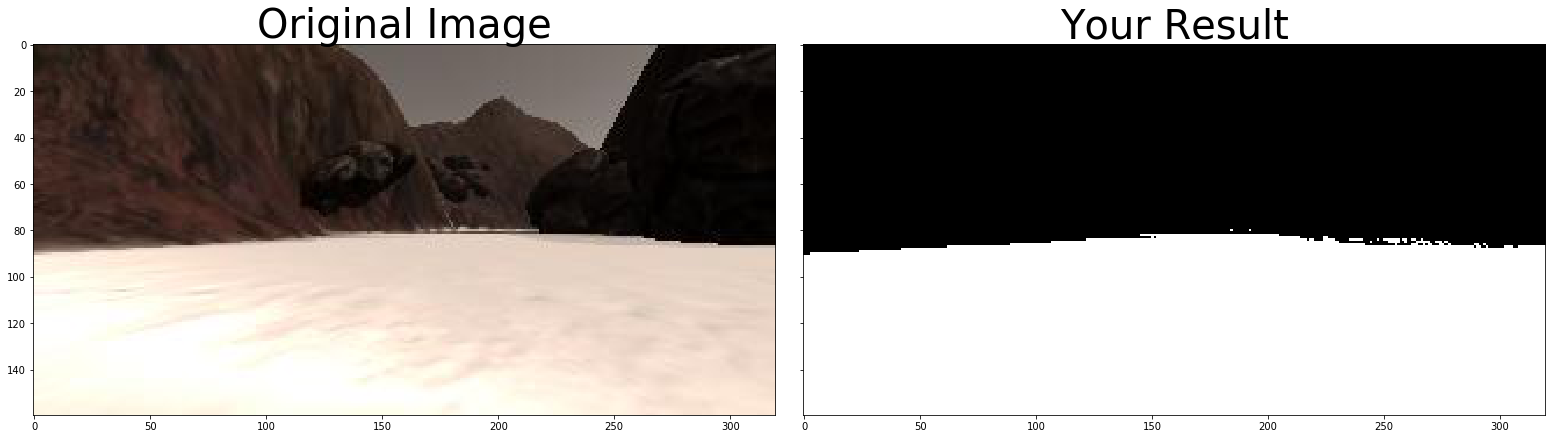

In [10]:
# Define a function to perform a color threshold
def color_thresh(img, rgb_thresh=(100, 100, 100)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select
    
# Define color selection criteria
###### TODO: MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 170
green_threshold = 170
blue_threshold = 170
    
rgb_threshold = (red_threshold, green_threshold, blue_threshold)

# pixels below the thresholds
colorsel = color_thresh(image, rgb_thresh=rgb_threshold)

# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 7), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(colorsel, cmap='gray')
ax2.set_title('Your Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.show() # Uncomment if running on your local machine

[[14, 140], [301, 140], [200, 96], [118, 96]]
[[155.0, 154], [165.0, 154], [165.0, 144], [155.0, 144]]


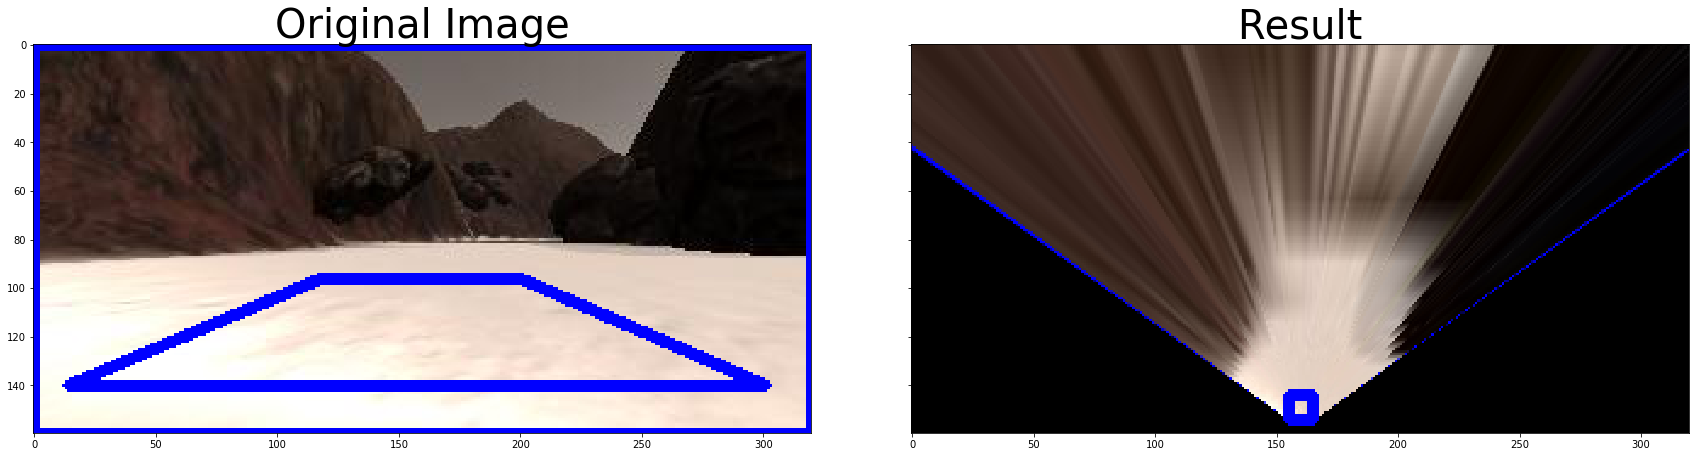

In [23]:
import cv2


def perspect_transform(img, src, dst):

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped

# TODO:
# Define a box in source (original) and 
# destination (desired) coordinates
# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
dst_size = 5
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6

print([[14, 140], [301 ,140],[200, 96], [118, 96]])
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])

print([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])


warped = perspect_transform(image, source, destination)
# Draw Source and destination points on images (in blue) before plotting
cv2.polylines(image, np.int32([source]), True, (0, 0, 255), 3)
cv2.polylines(warped, np.int32([destination]), True, (0, 0, 255), 3)
# Display the original image and binary               
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped, cmap='gray')
ax2.set_title('Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() # Uncomment if running on your local machine

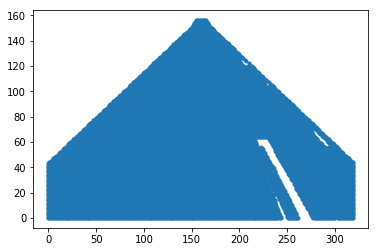

In [32]:
ypos, xpos = warped[:,:,2].nonzero()
plt.plot(xpos, ypos, '.')

In [34]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


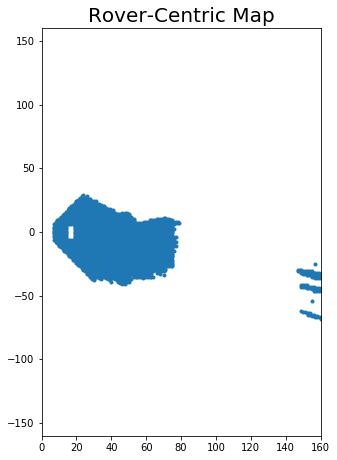

In [40]:
warped = perspect_transform(image, source, destination)
colorsel = color_thresh(warped, rgb_thresh=(160, 160, 160))

xpix, ypix = rover_coords(colorsel)

# Plot the map in rover-centric coords
fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
plt.title('Rover-Centric Map', fontsize=20)
plt.show() # Uncomment if running on your local machine